# Tutorial #2 - Basic - Generating fingerprints and running multiple jobs

This tutorial will cover: 
* Running multiple jobs sequentially vs in parallel
* Generate different flavors of IFP and convert them to RDKit-like objects and then compute Tanimoto similarity
* Plotting heatmaps for summarizing the interactions
* Plotting a Pymol session for superposed complexes

In [1]:
import matplotlib.pyplot as plt
import multiprocessing as mp
import time
import os

### Import LUNA

In [15]:
import luna

luna.version

'0.12.0'

### Reload the project created at Tutorial #1

In [3]:
proj_obj = luna.projects.LocalProject.load("./outputs/luna_results")

print("# Entries defined previously: ", len(proj_obj.entries))

for res in proj_obj.results:
    print(res.entry.to_string(), "  =>  # interactions: ", len(res.interactions_mngr))

[2022-10-05 23:48:06]    INFO            projects.py:982        Reloading project saved in './outputs/luna_results/project_v0.12.0.pkl.gz'.

[2022-10-05 23:48:06]    INFO            projects.py:557        Verbosity set to: 3 (INFO).
[2022-10-05 23:48:06]    INFO            projects.py:557        Project reloaded successfully.
# Entries defined previously:  5
D4:ZINC000012442563   =>  # interactions:  68
D4:ZINC000065293174   =>  # interactions:  61


/media/data/Workspace/Keiser lab/LUNA/luna/projects.py:989: LUNAWarning: Logging mode was set ON. Logging information will be saved from now on.
  proj_obj.logging_enabled = logging_enabled


D4:ZINC000096459890   =>  # interactions:  59
D4:ZINC000343043015   =>  # interactions:  52
D4:ZINC000575033470   =>  # interactions:  76


### Create new Fingerprints

After reloading a project, you can create fingerprints without having to recalculate interactions. By doing so, you can create different fingerprints by varying the IFP parameters if you will.

In [4]:
from luna.interaction.fp.type import IFPType

In [5]:
proj_obj.calc_ifp = True # interaction fingerprint

proj_obj.ifp_type = IFPType.EIFP # Type of fingerprints: EIFP, FIFP, or HIFP
proj_obj.ifp_count = True # Choose between count and bit fingerprint

proj_obj.ifp_num_levels = 6 # IFP parameter: number of levels
proj_obj.ifp_radius_step = 2 # IFP parameter: radius growth
proj_obj.ifp_length = 4096 # IFP parameter: size of the fingerprint

To create the fingerprints with the modified parameters, call the function **generate_ifps()**:

In [6]:
proj_obj.generate_ifps()

[2022-10-05 23:48:15]    INFO            projects.py:557        Preparing project directory '/media/data/Workspace/Keiser lab/LUNA/tutorial/outputs/luna_results'.
[2022-10-05 23:48:15]    INFO                file.py:191        The directory '/media/data/Workspace/Keiser lab/LUNA/tutorial/outputs/luna_results' already exists, but it will not be cleared.
[2022-10-05 23:48:15]    INFO                file.py:191        The directory '/media/data/Workspace/Keiser lab/LUNA/tutorial/outputs/luna_results/results' already exists, but it will not be cleared.
[2022-10-05 23:48:15]    INFO            projects.py:557        Project directory '/media/data/Workspace/Keiser lab/LUNA/tutorial/outputs/luna_results' created successfully.


/home/afassio/miniconda3/envs/luna-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: LUNADeprecationWarning: Function `generate_ifps` was deprecated in 0.12.0 and will be removed in 0.13.0. Use the general `generate_fps` instead.
  """Entry point for launching an IPython kernel.
[2022-10-05 23:48:15]    INFO            projects.py:557        Logging file '/media/data/Workspace/Keiser lab/LUNA/tutorial/outputs/luna_results/logs/project.log' initialized successfully.
[2022-10-05 23:48:15]    INFO            projects.py:557        Fingerprint generation will start. Number of entries to be processed is: 5.
[2022-10-05 23:48:15]    INFO            projects.py:557        The number of processes was set to: None.


[2022-10-05 23:48:20]    PROGRESS                               100% [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■] 5/5 [Avg: 1.11s/task; Errors: 0] - Fingerprint generation.

[2022-10-05 23:48:20]    INFO            projects.py:557        Fingerprint generation finished successfully.


[2022-10-05 23:48:21]    INFO            projects.py:557        Total processing time: 6.05s.
[2022-10-05 23:48:21]    INFO            projects.py:557        Results were saved at /media/data/Workspace/Keiser lab/LUNA/tutorial/outputs/luna_results.




The default output is saved at <WORKING-PATH>/results/fingerprints/ifp.csv, but you can also indicate the output filename if you will.


In [7]:
proj_obj.ifp_output = "./outputs/new_output_file.csv"

### Evaluate results

The results for each individual entry can be accessed through the EntryResult.

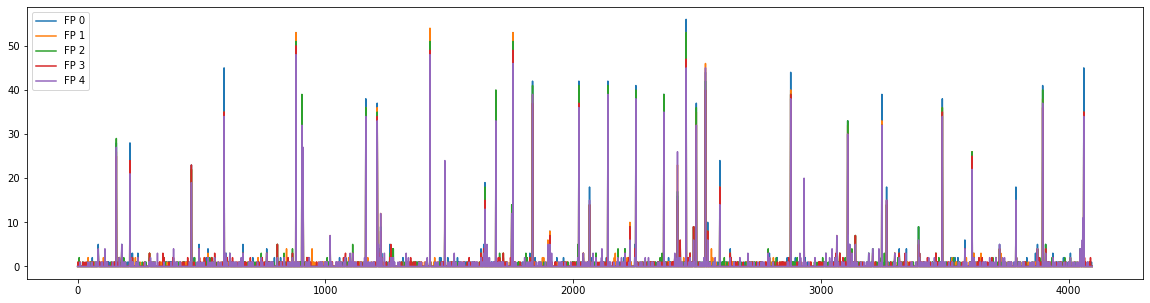

In [7]:
fig, ax = plt.subplots(figsize=(20, 5))

for i, entry in enumerate(proj_obj.entries):
    fp = proj_obj.get_entry_results(entry).ifp
    plot_vals = [fp.counts[i] if i in fp.counts else 0 for i in range(1, fp.fp_length + 1)]
    ax.plot(plot_vals, label = f"FP {i}")
plt.legend()

#### Density - how populated is the fingerprint

(array([1., 1., 0., 0., 1., 0., 1., 0., 0., 1.]),
 array([0.11254883, 0.11479492, 0.11704102, 0.11928711, 0.1215332 ,
        0.1237793 , 0.12602539, 0.12827148, 0.13051758, 0.13276367,
        0.13500977]),
 <BarContainer object of 10 artists>)

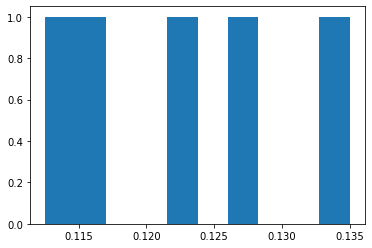

In [8]:
densities = [proj_obj.get_entry_results(entry).ifp.density for entry in proj_obj.entries]
plt.hist(densities)

#### Tanimoto coefficient - how similar are two fingerprints

You can calculate the similarity between two fingerprints using the function **calc_similarity()** from the fingerprint object.

(array([2., 0., 0., 0., 0., 1., 0., 0., 0., 1.]),
 array([0.22133939, 0.22323457, 0.22512976, 0.22702495, 0.22892014,
        0.23081532, 0.23271051, 0.2346057 , 0.23650089, 0.23839607,
        0.24029126]),
 <BarContainer object of 10 artists>)

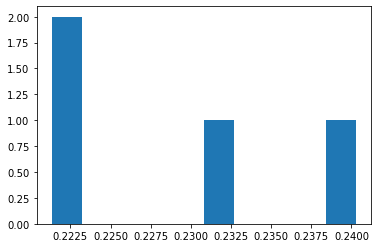

In [9]:
# Get a list of tuples where the first element is an entry and the second is an IFP.
ifps = list(proj_obj.ifps)

tanimotos = [ifps[0][1].calc_similarity(ifps[i][1]) for i in range(1,5)]

plt.hist(tanimotos)

## Export shells to Pymol sessions

To export shells to Pymol, you first need to create a **ShellGenerator** object that create shells for a given entry. As a result, it produces a **ShellManager** object. With a ShellManager you can access the created shells, create fingerprints, and trace back bit positions at a fingerprint back to its original shell.

In [10]:
from luna.interaction.fp.shell import ShellGenerator
from luna.interaction.fp.view import ShellViewer

In [ ]:
target_entry = proj_obj.entries[0]
agm = proj_obj.get_entry_results(target_entry).atm_grps_mngr

sg = ShellGenerator(proj_obj.ifp_num_levels, proj_obj.ifp_radius_step, diff_comp_classes=proj_obj.ifp_diff_comp_classes, ifp_type=proj_obj.ifp_type)
sm = sg.create_shells(agm)

print("# shells: ", len(sm.shells))

# shells:  1978


In [ ]:
psv = ShellViewer(add_directional_arrows=False)

# Let's select some shells. In this example, we are selecting only unique shells at level 4.
shells = sm.get_shells_by_level(4, unique_shells=True)
print("# shells at level 4: ", len(shells))

# Create a list of tuples, where the first item is the entry and the second item is the shells you want to visualize.
# In this example, let's visualize just the first five selected shells.
shell_tuples = [(target_entry, shells[0:6], proj_obj.pdb_path)]

# Define the output file. Note that all shells will be saved at the same Pymol session.
pse_file = "./outputs/shells_at_level4.pse"
psv.new_session(shell_tuples, pse_file)

# shells at level 4:  69
 Using Python 2 compatible legacy pickler
 Applying pse_export_version=1.800 compatibility


## Trace back a feature to its shell

To trace a feature in the fingerprint back to its shell, you need to use the function **trace_back_feature()** available at ShellManager objects.

In [ ]:
ifp = sm.to_fingerprint(fold_to_length=4096, unique_shells=True, count_fp=False)

# Trace back the first feature set ON in the fingerprint.
recoved_shells = sm.trace_back_feature(ifp.get_on_bits()[0], ifp)

# As collisions may occur in a fingerprint, the trace_back_feature returns all shells collided in a given feature id.
for ori_feature, found_shells in recoved_shells:
    print("Shell id: %s" % ori_feature)
    print("  - Number of shells containing this id: %d." % len(found_shells))
    print()

Shell id: 1517445126
  - Number of shells containing this id: 1.

